In [101]:
import pandas as pd
import onc
import os
import json
from dotenv import load_dotenv
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


load_dotenv()
token = os.getenv("ONC_TOKEN")

# Create ONC client using the SDK
my_onc = onc.ONC(token)


In [102]:
"""
Fetches scalar data using the ONC Python SDK for a given location, device category, property (sensorCategoryCode) and time window.
Returns a dataframe with timestamps, values and flags.
"""

def get_property(start: str, end: str, locationCode: str, deviceCategoryCode: str, sensorCategoryCode: str) -> pd.DataFrame:

    params = {
        "locationCode": locationCode,
        "deviceCategoryCode": deviceCategoryCode,
        "sensorCategoryCodes": sensorCategoryCode,
        "dateFrom": start,
        "dateTo" : end
    }

    # JSON response from ONC
    result = my_onc.getScalardata(params)

    # error handle if there is no data returned
    if not result or "sensorData" not in result or result["sensorData"] is None or len(result["sensorData"]) == 0:
        print(f"No data returned for devices in {deviceCategoryCode} at {locationCode} between {start} and {end}.")
        return
        
    else:
        # extract the relevant sensors
        sensor = result["sensorData"][0]
        
        # extract each sensors data fields
        times = sensor["data"]["sampleTimes"]
        values = sensor["data"]["values"]
        flags = sensor["data"]["qaqcFlags"] # flags for quality assurance
        unit = sensor["unitOfMeasure"]

        # populate dataframe (Pandas)
        df = pd.DataFrame({
            # syntax: "label": variable
            "timestamp": pd.to_datetime(times), # convert strings to datetime objects
            f"{sensorCategoryCode}": values,
            "qaqcFlags": flags,
            "uom": unit
        })
        
    print(df)
    return(df)

In [103]:


def detect_cast_intervals(df: pd.DataFrame, gap_threshold_minutes: int = 10) -> List[Tuple[str, str]]:
    """
    Detects individual CTD cast intervals based on time gaps in the data.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'timestamp' column (datetime format).
        gap_threshold_minutes (int): Time gap threshold to detect breaks between casts.

    Returns:
        List[Tuple[str, str]]: List of (dateFrom, dateTo) pairs in ISO 8601 UTC format.
    """
    if df.empty or "timestamp" not in df.columns:
        return []

    # Sort and reset index
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Calculate time gaps between consecutive timestamps
    gaps = df["timestamp"].diff().fillna(pd.Timedelta(seconds=0))
    new_cast_starts = df.index[gaps > pd.Timedelta(minutes=gap_threshold_minutes)].tolist()

    # Start of first cast is always 0
    cast_starts = [0] + new_cast_starts
    cast_ends = new_cast_starts + [len(df)]

    # Format intervals as ISO 8601 with milliseconds and Z (UTC)
    intervals = []
    for start_idx, end_idx in zip(cast_starts, cast_ends):
        start = df["timestamp"].iloc[start_idx].strftime("%Y-%m-%dT%H:%M:%S.000Z")
        end = df["timestamp"].iloc[end_idx - 1].strftime("%Y-%m-%dT%H:%M:%S.000Z")
        intervals.append((start,end))

    return intervals


In [ ]:
def plot_cast_property(start: str, end: str, locationCode: str, deviceCategoryCode: str,
                  sensorCategoryCode: str, df: pd.DataFrame) -> None:
    """
    Plots a sensor property time-series with optional cast interval markers.

    Parameters:
        start (str): Start time in ISO 8601 format.
        end (str): End time in ISO 8601 format.
        locationCode (str): ONC location code.
        deviceCategoryCode (str): ONC device category.
        sensorCategoryCode (str): Sensor property (e.g., "depth").
        df (pd.DataFrame): DataFrame containing 'timestamp' and property column.
    """
    # format tiem strings to timedetla
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)

    df_int = df[(df["timestamp"] >= start_dt) & (df["timestamp"] <= end_dt)]

    
    df_int.plot(x="timestamp",y="depth", title=f"{deviceCategoryCode} {sensorCategoryCode} at {locationCode} on Jul-11-2023")


                            timestamp      depth  qaqcFlags uom
0    2023-07-11 17:12:51.030000+00:00   1.157053          1   m
1    2023-07-11 17:12:51.190000+00:00   1.177540          1   m
2    2023-07-11 17:12:51.360000+00:00   1.180510          1   m
3    2023-07-11 17:12:51.520000+00:00   1.235587          1   m
4    2023-07-11 17:12:51.680000+00:00   1.360663          1   m
...                               ...        ...        ...  ..
1348 2023-07-11 20:15:39.260000+00:00  27.452450          1   m
1349 2023-07-11 20:15:39.430000+00:00  27.524826          1   m
1350 2023-07-11 20:15:39.550000+00:00  27.578312          1   m
1351 2023-07-11 20:15:39.710000+00:00  27.673582          1   m
1352 2023-07-11 20:15:39.880000+00:00  27.754850          1   m

[1353 rows x 4 columns]


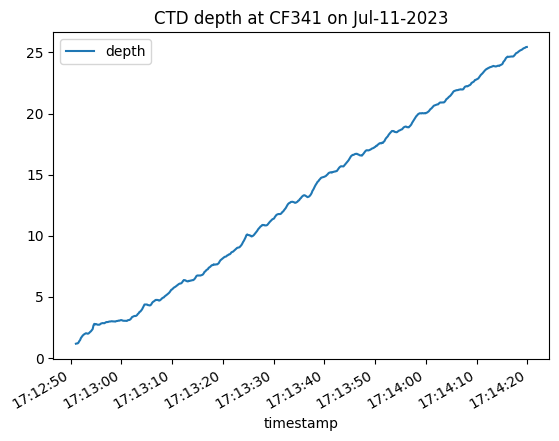

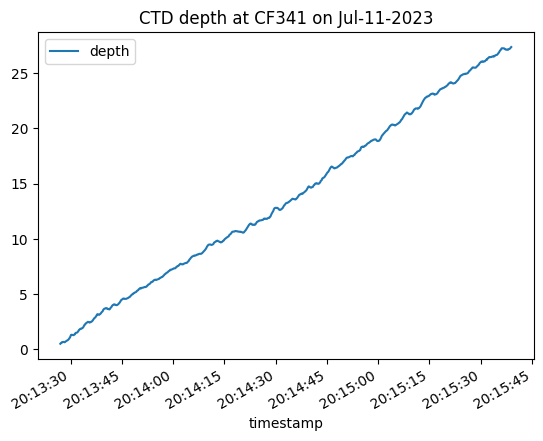

In [105]:
dateFrom = "2023-07-11T17:00:00.000Z"
dateTo = "2023-07-11T22:30:00.000Z"

df = get_property(dateFrom, dateTo, "CF341", "CTD", "depth") # populate dataframe of entire day

cast_ints = detect_cast_intervals(df) # isolate time intervals for each cast

# plot property for each cast interval 

for cast_start, cast_end in cast_ints:  
   #print(f"{cast_start}, {cast_end}")
   plot_cast_property(cast_start, cast_end, "CF341", "CTD", "depth", df)
